# Examples

## Importing packages

In the examples below, we will be using the classes `WrapClassifier` and `WrapRegressor` from the `crepes` package. These classes rely on the classes `ConformalClassifier`, `ConformalRegressor`, and `ConformalPredictiveSystem` from the same package, which however will not be explicitly interfaced in the examples here; see [More examples](https://crepes.readthedocs.io/en/latest/crepes_nb.html) for how to obtain the same results as in this section by using these classes instead. The examples below also use a helper class and functions from `crepes.extras`, as well as the `NumPy`, `pandas`, `matplotlib` and `sklearn` libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from crepes import WrapClassifier, WrapRegressor, __version__

from crepes.extras import margin, DifficultyEstimator, binning

print(f"crepes v. {__version__}")

np.random.seed(602211023)

crepes v. 0.6.2


## Conformal classifiers (CC)

### Importing and splitting a classification dataset

Let us import a classification dataset from [www.openml.org](https://www.openml.org).

In [2]:
dataset = fetch_openml(name="gas-drift", parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values

We now split the dataset into a training and a test set, and further split the training set into a proper training set and a calibration set.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

### Standard conformal classifier

Let us create a standard conformal classifier through a `WrapClassifier` object, using a random forest that is fitted in the usual way (using the proper training set only), before or after being wrapped:

In [4]:
rf = WrapClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=500))

rf.fit(X_prop_train, y_prop_train)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=False)

We will use the the calibration set to calibrate the conformal regressor; note that the `calibrate` method has been added to the wrapped learner, in addition to the standard `fit`and `predict` methods. 

In [5]:
rf.calibrate(X_cal, y_cal)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=False))

We may now obtain prediction sets for the test set using the new method `predict_set`; 
here using the default confidence level (95%).

In [6]:
prediction_sets = rf.predict_set(X_test)

display(prediction_sets)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

For each object in the test set, we get a prediction set, i.e., a binary vector indicating the presence (1) or absence (0) of each class label. The columns are ordered according to `classes_` of the underlying learner:

In [7]:
rf.learner.classes_ 

array(['1', '2', '3', '4', '5', '6'], dtype=object)

We may specify any confidence level that we are interested in, e.g., 99%. By increasing the confidence level, fewer possible labels get rejected:

In [8]:
prediction_sets = rf.predict_set(X_test, confidence=0.99)

display(prediction_sets)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

We may also get the p-values (without specifying any confidence level) by:

In [9]:
p_values = rf.predict_p(X_test)

display(p_values)

array([[7.11853998e-02, 6.81623163e-04, 7.51952414e-05, 7.22822111e-03,
        1.83551541e-03, 1.25354912e-03],
       [7.69995483e-04, 4.02198309e-01, 3.28246348e-03, 8.46337362e-04,
        1.03880711e-03, 1.29555038e-03],
       [1.65747617e-03, 1.16900791e-03, 2.02917868e-04, 5.02167131e-05,
        7.65836044e-01, 1.70578620e-03],
       ...,
       [1.30852359e-03, 1.38763636e-03, 2.20624808e-03, 4.54321090e-03,
        2.99559728e-03, 2.06218609e-01],
       [1.89321540e-03, 1.75937091e-03, 1.64400289e-03, 6.98791143e-03,
        2.22087512e-03, 1.16866012e-01],
       [2.90605130e-03, 1.94900613e-03, 1.74838116e-03, 3.30855703e-03,
        7.68918667e-02, 7.03350329e-03]])

By default, the conformal classifiers obtained using `WrapClassifier` will compute non-conformity scores using the `hinge` function defined in `crepes.extras`. We could alternatively generate a conformal classifier using the `margin` function, which we imported above:

In [10]:
rf_margin = WrapClassifier(rf.learner)

rf_margin.calibrate(X_cal, y_cal, nc=margin)

display(rf_margin)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=False))

### Mondrian conformal classifiers

To control the error level across different groups of objects of interest, we may use so-called Mondrian conformal classifiers.
A Mondrian conformal classifier is formed by providing the names of the categories
as an additional argument, named `bins`, for the `calibrate` method.

We can form the Mondrian categories in any way we like, as long as we only
use information that is available for both calibration and test instances;
this means that we may not use the target values for this purpose, since these will 
typically not be available for the test instances. 

For illustration, we will consider two categories formed by whether the first feature value is larger than 50 000 or not:

In [11]:
bins_cal = X_cal[:,0] > 50000

rf_mond = WrapClassifier(rf.learner)

rf_mond.calibrate(X_cal, y_cal, bins=bins_cal)

display(rf_mond)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

Let us now obtain the categories for the test instances using the
same Mondrian categorization, and form prediction sets for the test objects:

In [12]:
bins_test = X_test[:,0] > 50000

prediction_sets_mond = rf_mond.predict_set(X_test, bins=bins_test)

display(prediction_sets_mond)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

### Class-conditional conformal classifiers

Class-conditional conformal classifiers is a special type of Mondrian conformal classifiers where the categories are defined by the class labels.
The test objects need special treatment since we do not know to which categories they belong; a non-conformity score (p-value) is generated for each possible class label. Since this is a common type of conformal classifier, and it is a bit tricky to handle the test objects in the above way, the `calibrate` method has a specific option (`class_cond`) to enable it, as shown below:

In [13]:
rf_class_cond = WrapClassifier(rf.learner)

rf_class_cond.calibrate(X_cal, y_cal, class_cond=True)

display(rf_class_cond)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

When forming prediction sets for the test objects, we should not provide any bins for the class-conditional conformal classifier:

In [14]:
prediction_sets_class_cond = rf_class_cond.predict_set(X_test)

display(prediction_sets_class_cond)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

### Evaluating the conformal classifiers

Since we have access to the correct class labels for the test set, we can investigate the predictive performance of the conformal classifiers.
Let us start with the standard conformal classifier (which uses the default `hinge` function to compute non-conformity scores):

In [15]:
rf.evaluate(X_test, y_test)

{'error': 0.04025880661394676,
 'avg_c': 0.9611790079079798,
 'one_c': 0.9611790079079798,
 'empty': 0.038820992092020126,
 'time_fit': 0.0001010894775390625,
 'time_evaluate': 0.15152478218078613}

Above we used the default (95%) confidence level, but we could specify some other:

In [16]:
rf.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.08454349388928828,
 'avg_c': 0.9166067577282531,
 'one_c': 0.9166067577282531,
 'empty': 0.08339324227174695,
 'time_fit': 0.0001010894775390625,
 'time_evaluate': 0.14511370658874512}

Let us also evaluate the standard conformal classifier that uses the `margin` function to compute non-conformity scores:

In [17]:
rf_margin.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.08411214953271029,
 'avg_c': 0.917038102084831,
 'one_c': 0.917038102084831,
 'empty': 0.08296189791516895,
 'time_fit': 7.224082946777344e-05,
 'time_evaluate': 0.346146821975708}

When evaluating a Mondrian conformal classifier, we also need to provide the Mondrian categories for the test set:

In [18]:
rf_mond.evaluate(X_test, y_test, bins=bins_test, confidence=0.9)

{'error': 0.08396836808051766,
 'avg_c': 0.9171818835370237,
 'one_c': 0.9171818835370237,
 'empty': 0.08281811646297628,
 'time_fit': 0.0002281665802001953,
 'time_evaluate': 0.17641925811767578}

For the class-conditional conformal classifier, we should not provide any Mondrian categories:

In [19]:
rf_class_cond.evaluate(X_test, y_test, confidence=0.9)

{'error': 0.08914450035945365,
 'avg_c': 0.9118619698058951,
 'one_c': 0.9118619698058951,
 'empty': 0.08813803019410496,
 'time_fit': 0.0006880760192871094,
 'time_evaluate': 0.38990259170532227}

We may evaluate the conformal classifiers on each class separately. For the standard conformal classifier, we get:

In [20]:
for c in rf.learner.classes_:
    print(f"Class {c}:")
    display(rf.evaluate(X_test[y_test == c], y_test[y_test == c], confidence=0.9))
    print("")

Class 1:


{'error': 0.06692607003891049,
 'avg_c': 0.9330739299610895,
 'one_c': 0.9330739299610895,
 'empty': 0.0669260700389105,
 'time_fit': 0.0001010894775390625,
 'time_evaluate': 0.0694570541381836}


Class 2:


{'error': 0.05842391304347827,
 'avg_c': 0.9429347826086957,
 'one_c': 0.9429347826086957,
 'empty': 0.057065217391304345,
 'time_fit': 0.0001010894775390625,
 'time_evaluate': 0.07000422477722168}


Class 3:


{'error': 0.08222490931076176,
 'avg_c': 0.9238210399032648,
 'one_c': 0.9238210399032648,
 'empty': 0.0761789600967352,
 'time_fit': 0.0001010894775390625,
 'time_evaluate': 0.06342411041259766}


Class 4:


{'error': 0.15583075335397312,
 'avg_c': 0.8441692466460269,
 'one_c': 0.8441692466460269,
 'empty': 0.15583075335397317,
 'time_fit': 0.0001010894775390625,
 'time_evaluate': 0.06589365005493164}


Class 5:


{'error': 0.07702612190221036,
 'avg_c': 0.9229738780977896,
 'one_c': 0.9229738780977896,
 'empty': 0.07702612190221031,
 'time_fit': 0.0001010894775390625,
 'time_evaluate': 0.07214140892028809}


Class 6:


{'error': 0.09020902090209026,
 'avg_c': 0.9108910891089109,
 'one_c': 0.9108910891089109,
 'empty': 0.0891089108910891,
 'time_fit': 0.0001010894775390625,
 'time_evaluate': 0.06585288047790527}

As can be observed above, a standard conformal classifier may significantly exceed the error level when considering each class separately. This contrasts to the class-condition conformal classifier:

In [21]:
for c in rf.learner.classes_:
    print(f"Class {c}:")
    display(rf_class_cond.evaluate(X_test[y_test == c], y_test[y_test == c], confidence=0.9))
    print("")

Class 1:


{'error': 0.08949416342412453,
 'avg_c': 0.9105058365758755,
 'one_c': 0.9105058365758755,
 'empty': 0.08949416342412451,
 'time_fit': 0.0006880760192871094,
 'time_evaluate': 0.1176753044128418}


Class 2:


{'error': 0.10529891304347827,
 'avg_c': 0.8960597826086957,
 'one_c': 0.8960597826086957,
 'empty': 0.10394021739130435,
 'time_fit': 0.0006880760192871094,
 'time_evaluate': 0.12558889389038086}


Class 3:


{'error': 0.09552599758162028,
 'avg_c': 0.909310761789601,
 'one_c': 0.909310761789601,
 'empty': 0.09068923821039904,
 'time_fit': 0.0006880760192871094,
 'time_evaluate': 0.09272027015686035}


Class 4:


{'error': 0.09597523219814241,
 'avg_c': 0.9040247678018576,
 'one_c': 0.9040247678018576,
 'empty': 0.09597523219814241,
 'time_fit': 0.0006880760192871094,
 'time_evaluate': 0.09717607498168945}


Class 5:


{'error': 0.0877427997320831,
 'avg_c': 0.9122572002679169,
 'one_c': 0.9122572002679169,
 'empty': 0.08774279973208306,
 'time_fit': 0.0006880760192871094,
 'time_evaluate': 0.12543201446533203}


Class 6:


{'error': 0.0517051705170517,
 'avg_c': 0.9493949394939494,
 'one_c': 0.9493949394939494,
 'empty': 0.050605060506050605,
 'time_fit': 0.0006880760192871094,
 'time_evaluate': 0.09749603271484375}

### Conformal classifiers without a separate calibration set

For conformal classifiers that employ learners that use bagging, like random forests, we may consider an alternative strategy to dividing the original training set into a proper training and calibration set; we may use the out-of-bag (OOB) predictions, which allow us to use the full training set for both model building and calibration. It should be noted that this strategy does not come with the theoretical validity guarantee of the above (inductive) conformal classifiers, due to that calibration and test instances are not handled in exactly the same way. In practice, however, conformal classifiers based on out-of-bag predictions rarely fail to meet the coverage requirements.

#### Standard conformal classifiers with out-of-bag calibration

Let us first generate a model from the full training set, making sure the learner has an attribute `oob_decision_function_`, which e.g. is the case for a `RandomForestClassifier` if `oob_score` is set to `True` when created.

In [22]:
learner_full = RandomForestClassifier(n_jobs=-1, n_estimators=500, oob_score=True)

rf = WrapClassifier(learner_full)

rf.fit(X_train, y_train)

We may now obtain a standard conformal regressor using OOB predictions:

In [23]:
rf.calibrate(X_train, y_train, oob=True)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=False))

... and use it to get prediction sets for the test set:

In [24]:
prediction_sets_oob = rf.predict_set(X_test)

display(prediction_sets_oob)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

#### Mondrian conformal classifiers with out-of-bag calibration

Using out-of-bag calibration works equally well for Mondrian conformal classifiers:

In [25]:
bins_oob = X_train[:,0] > 50000

rf.calibrate(X_train, y_train, bins=bins_oob, oob=True)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

Prediction sets for the test objects are obtained in the following way:

In [26]:
prediction_sets_mond_oob = rf.predict_set(X_test, bins=bins_test)

display(prediction_sets_oob)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

We may of course evaluate the Mondrian conformal classifier using out-of-bag predictions too:

In [27]:
results = rf.evaluate(X_test, y_test, bins=bins_test)

display(results)

{'error': 0.04529115744069012,
 'avg_c': 0.9558590941768512,
 'one_c': 0.9558590941768512,
 'empty': 0.044140905823148814,
 'time_fit': 0.00035953521728515625,
 'time_evaluate': 0.1774587631225586}

#### Class-conditional conformal classifiers with out-of-bag calibration

Unsurprisingly, since a class-conditional conformal classifier is a special type of Mondrian conformal classifier, we can use out-of-bag calibration for them too:

In [28]:
rf.calibrate(X_train, y_train, class_cond=True, oob=True)

display(rf)

WrapClassifier(learner=RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalClassifier(fitted=True, mondrian=True))

Prediction sets for the test objects are obtained in the following way:

In [29]:
prediction_sets_class_cond_oob = rf.predict_set(X_test)

display(prediction_sets_class_cond_oob)

array([[0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

Finally, for completeness, we show that a class-conditional conformal classifier formed using out-of-bag calibration may be evaluated too:

In [30]:
results = rf.evaluate(X_test, y_test)

display(results)

{'error': 0.04442846872753414,
 'avg_c': 0.9565780014378146,
 'one_c': 0.9565780014378146,
 'empty': 0.043421998562185475,
 'time_fit': 0.0015361309051513672,
 'time_evaluate': 0.389479398727417}

Let us also check the performance for the classes separately:

In [31]:
for c in rf.learner.classes_:
    print(f"Class {c}:")
    display(rf.evaluate(X_test[y_test == c], y_test[y_test == c], confidence=0.9))
    print("")

Class 1:


{'error': 0.10116731517509725,
 'avg_c': 0.8988326848249028,
 'one_c': 0.8988326848249028,
 'empty': 0.10116731517509728,
 'time_fit': 0.0015361309051513672,
 'time_evaluate': 0.11318778991699219}


Class 2:


{'error': 0.11345108695652173,
 'avg_c': 0.8879076086956522,
 'one_c': 0.8879076086956522,
 'empty': 0.11209239130434782,
 'time_fit': 0.0015361309051513672,
 'time_evaluate': 0.12507271766662598}


Class 3:


{'error': 0.11003627569528418,
 'avg_c': 0.8923821039903265,
 'one_c': 0.8923821039903265,
 'empty': 0.10761789600967352,
 'time_fit': 0.0015361309051513672,
 'time_evaluate': 0.09334659576416016}


Class 4:


{'error': 0.09597523219814241,
 'avg_c': 0.9040247678018576,
 'one_c': 0.9040247678018576,
 'empty': 0.09597523219814241,
 'time_fit': 0.0015361309051513672,
 'time_evaluate': 0.09832000732421875}


Class 5:


{'error': 0.0964501004688546,
 'avg_c': 0.9035498995311454,
 'one_c': 0.9035498995311454,
 'empty': 0.09645010046885466,
 'time_fit': 0.0015361309051513672,
 'time_evaluate': 0.1262190341949463}


Class 6:


{'error': 0.06820682068206818,
 'avg_c': 0.9328932893289329,
 'one_c': 0.9328932893289329,
 'empty': 0.0671067106710671,
 'time_fit': 0.0015361309051513672,
 'time_evaluate': 0.09899425506591797}

## Conformal regressors (CR)

### Importing and splitting a regression dataset

Let us import a dataset from [www.openml.org](https://www.openml.org) and min-max normalize the targets; the latter is not really necessary, but useful, allowing to directly compare the size of a prediction interval to the whole target range, which becomes 1.0 in this case.

In [32]:
dataset = fetch_openml(name="house_sales", version=3, parser="auto")

X = dataset.data.values.astype(float)
y = dataset.target.values.astype(float)

y = np.array([(y[i]-y.min())/(y.max()-y.min()) for i in range(len(y))])

We now split the dataset into a training and a test set, and further split the training set into a proper training set and a calibration set.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

### Standard conformal regressors

Let us create a conformal regressor through a `WrapRegressor` object, using a random forest that is fitted in the usual way (using the proper training set only), before or after being wrapped:

In [34]:
rf = WrapRegressor(RandomForestRegressor(n_jobs=-1, n_estimators=500, oob_score=True))

rf.fit(X_prop_train, y_prop_train)

display(rf)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=False)

We will use the the calibration set to calibrate the conformal regressor; note that the `calibrate` method has been added to the wrapped learner, in addition to the standard `fit`and `predict` methods. 

In [35]:
rf.calibrate(X_cal, y_cal)

display(rf)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=False))

We may now obtain prediction intervals for the test set using the new method `predict_int`; 
here using a confidence level of 99%.

In [36]:
intervals = rf.predict_int(X_test, confidence=0.99)

display(intervals)

array([[-0.00991523,  0.1294108 ],
       [-0.01314784,  0.12617819],
       [-0.0205007 ,  0.11882533],
       ...,
       [-0.01698495,  0.12234107],
       [-0.02710331,  0.11222271],
       [ 0.05782889,  0.19715492]])

We may request that the intervals are cut to exclude impossible values, in this case below 0 and above 1; below we also use the default 
confidence level (95%), which further tightens the intervals.

In [37]:
intervals_std = rf.predict_int(X_test, y_min=0, y_max=1)

display(intervals_std)

array([[0.02961503, 0.08988054],
       [0.02638242, 0.08664794],
       [0.01902955, 0.07929507],
       ...,
       [0.0225453 , 0.08281082],
       [0.01242694, 0.07269246],
       [0.09735915, 0.15762466]])

### Accessing the wrapped learner 

As shown above, we have access directly to some methods of the wrapped learner, e.g., through the `fit` and `predict` methods. We can also access the wrapped learner directly by the following:

In [38]:
learner_prop = rf.learner

This may be useful, e.g., in case a fitted wrapped learner is to be re-used in another conformal regressor, as we will see below.

### Normalized conformal regressors

The above intervals are not normalized, i.e., they are all of the same size (at least before they are cut). We could make the intervals more informative through normalization using difficulty estimates; 
more difficult instances will be assigned wider intervals. We can use a `DifficultyEstimator`, as imported from `crepes.extras`,  for this purpose. It can be used to estimate the difficulty by using k-nearest neighbors in three different ways: i) by the (Euclidean) distances to the nearest neighbors, ii) by the standard deviation of the targets of the nearest neighbors, and iii) by the absolute errors of the k nearest neighbors. 

A small value (beta) is added to the estimates, which may be given through a (named) argument to the `fit` method; we will just use the default for this, i.e., `beta=0.01`. In order to make the beta value have the same effect across different estimators, we may opt for normalizing the difficulty estimates (using min-max scaling) by setting `scaler=True`. It should be noted that this comes with a computational cost; for estimators based on the k-nearest neighbor, a leave-one-out protocol is employed to find the minimum and maximum distances that are used by the scaler.

We will first consider just using the first option (distances to the k-nearest neighbors) to produce normalized conformal regressors, using the default number of nearest neighbors, i.e., `k=25`.

In [39]:
de_knn = DifficultyEstimator()

de_knn.fit(X=X_prop_train, scaler=True)

display(de_knn)

sigmas_cal_knn_dist = de_knn.apply(X_cal)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=False)

We create a new (normalized) conformal regressor re-using the underlying (already fitted) learner of the previous conformal regressor, and calibrate it using both the residuals and the difficulty estimates:

In [40]:
rf_norm_knn_dist = WrapRegressor(learner_prop)

rf_norm_knn_dist.calibrate(X_cal, y_cal, sigmas=sigmas_cal_knn_dist)

display(rf_norm_knn_dist)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

To obtain prediction intervals for the test set, we need difficulty estimates for the latter too, which we get in the same way as for the calibration objects, and which are provided to the `predict_int` method: 

In [41]:
sigmas_test_knn_dist = de_knn.apply(X_test)

intervals_norm_knn_dist = rf_norm_knn_dist.predict_int(
    X_test, sigmas=sigmas_test_knn_dist, y_min=0, y_max=1)

display(intervals_norm_knn_dist)

array([[0.04099259, 0.07850298],
       [0.03873874, 0.07429161],
       [0.02622519, 0.07209944],
       ...,
       [0.        , 0.11391227],
       [0.01046511, 0.07465429],
       [0.0989153 , 0.15606851]])

Alternatively, we could estimate the difficulty using the standard deviation of the targets of the nearest neighbors; we specify this by providing the targets too to the `fit` method:

In [42]:
de_knn_std = DifficultyEstimator()

de_knn_std.fit(X=X_prop_train, y=y_prop_train, scaler=True)

display(de_knn_std)

sigmas_cal_knn_std = de_knn_std.apply(X_cal)

rf_norm_knn_std = WrapRegressor(learner_prop)

rf_norm_knn_std.calibrate(X_cal, y_cal, sigmas=sigmas_cal_knn_std)

display(rf_norm_knn_std)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=False)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

... and similarly for the test objects:

In [43]:
sigmas_test_knn_std = de_knn_std.apply(X_test)

intervals_norm_knn_std = rf_norm_knn_std.predict_int(
    X_test, sigmas=sigmas_test_knn_std, y_min=0, y_max=1)

display(intervals_norm_knn_std)

array([[0.0486073 , 0.07088827],
       [0.03179301, 0.08123734],
       [0.02415787, 0.07416675],
       ...,
       [0.        , 0.11002877],
       [0.02105587, 0.06406353],
       [0.07817031, 0.1768135 ]])

A third option is to use (absolute) residuals for the reference objects. For a model that overfits the training data, it can be a good idea to use a separate set of (reference) objects and labels from which the residuals could be calculated, rather than using the original training data. Since we in this case have trained a random forest, we opt for estimating the residuals by using the out-of-bag predictions for the training instances, where the latter are stored in `oob_prediction_` of the underlying lerner (as a consequence of setting `oob_score=True` for the `RandomForestRegressor` above.)

To inform the `fit` method that this is what we want to do, we provide a value for `residuals`, instead of `y` as we did above for the option to use the (standard deviation of) the targets.

In [44]:
oob_predictions = rf.learner.oob_prediction_

residuals_prop_oob = y_prop_train - oob_predictions

de_knn_res = DifficultyEstimator()

de_knn_res.fit(X=X_prop_train, residuals=residuals_prop_oob, scaler=True)

display(de_knn_res)

sigmas_cal_knn_res = de_knn_res.apply(X_cal)

rf_norm_knn_res = WrapRegressor(learner_prop)

rf_norm_knn_res.calibrate(X_cal, y_cal, sigmas=sigmas_cal_knn_res)

display(rf_norm_knn_res)

DifficultyEstimator(fitted=True, type=knn, k=25, target=residuals, scaler=True, beta=0.01, oob=False)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

... and again, the difficulty estimates are formed in the same way for the test objects:

In [45]:
sigmas_test_knn_res = de_knn_res.apply(X_test)

intervals_norm_knn_res = rf_norm_knn_res.predict_int(
    X_test, sigmas=sigmas_test_knn_res, y_min=0, y_max=1)

display(intervals_norm_knn_res)

array([[0.03941514, 0.08008043],
       [0.03440609, 0.07862426],
       [0.02341583, 0.07490879],
       ...,
       [0.01046725, 0.09488886],
       [0.01174784, 0.07337156],
       [0.1002838 , 0.15470001]])

In case we have trained an ensemble model, like a `RandomForestRegressor`, we could alternatively request `DifficultyEstimator` to estimate the difficulty by the variance of the predictions of the constituent models. This requires us to provide the trained model `learner` as input to `fit`, assuming that `learner.estimators_` is a collection of base models, each implementing the `predict` method; this holds e.g., for `RandomForestRegressor`. A set of objects (`X`) has to be provided only if we employ scaling (`scaler=True`).

In [46]:
de_var = DifficultyEstimator()

de_var.fit(X=X_prop_train, learner=learner_prop, scaler=True)

display(de_var)

sigmas_cal_var = de_var.apply(X_cal)

rf_norm_var = WrapRegressor(learner_prop)

rf_norm_var.calibrate(X_cal, y_cal, sigmas=sigmas_cal_var)

display(rf_norm_var)

DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

The difficulty estimates for the test set are generated in the same way:

In [47]:
sigmas_test_var = de_var.apply(X_test)

intervals_norm_var = rf_norm_var.predict_int(
    X_test, sigmas=sigmas_test_var, y_min=0, y_max=1)

display(intervals_norm_var)

array([[0.04204765, 0.07744792],
       [0.03762971, 0.07540064],
       [0.03060017, 0.06772446],
       ...,
       [0.03145619, 0.07389992],
       [0.022912  , 0.0622074 ],
       [0.09140717, 0.16357664]])

### Mondrian conformal regressors

An alternative way of generating prediction intervals of varying size
is to divide the object space into non-overlapping so-called Mondrian categories.
A Mondrian conformal regressor is formed by providing the names of the categories
as an additional argument, named `bins`, for the `calibrate` method.

Here we employ the helper function `binning`, imported from `crepes.extras`, which given a list/array of values
returns an array of the same length with the assigned bins. 
If the optional argument `bins` is an integer, the function will divide the values 
into equal-sized bins and return both the assigned bins and the bin boundaries. 
If `bins` instead is a set of bin boundaries, the function will just return the assigned bins.

We can form the Mondrian categories in any way we like, as long as we only
use information that is available for both calibration and test instances;
this means that we may not use the target values for this purpose, since these will 
typically not be available for the test instances. 
We will form categories by binning of the difficulty estimates, here using the
ones previously produced using the standard deviations of the nearest neighbor targets. 

In [48]:
bins_cal, bin_thresholds = binning(sigmas_cal_var, bins=20)

rf_mond = WrapRegressor(learner_prop)

rf_mond.calibrate(X_cal, y_cal, bins=bins_cal)

display(rf_mond)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=True))

Let us now obtain the categories for the test instances using the
same Mondrian categorization, i.e., bin borders.

In [49]:
bins_test = binning(sigmas_test_var, bins=bin_thresholds)

... and now we can form prediction intervals for the test instances.

In [50]:
intervals_mond = rf_mond.predict_int(X_test, bins=bins_test, y_min=0, y_max=1)

display(intervals_mond)

array([[0.04556184, 0.07393373],
       [0.03537992, 0.07765044],
       [0.03319999, 0.06512464],
       ...,
       [0.0222086 , 0.08314751],
       [0.02076563, 0.06435377],
       [0.07821874, 0.17676507]])

### Investigating the prediction intervals

Let us first put all the intervals in a dictionary.

In [51]:
prediction_intervals = {
    "Std CR":intervals_std,
    "Norm CR knn dist":intervals_norm_knn_dist,
    "Norm CR knn std":intervals_norm_knn_std,
    "Norm CR knn res":intervals_norm_knn_res,
    "Norm CR var":intervals_norm_var,
    "Mond CR":intervals_mond,
}

Let us see what fraction of the intervals that contain the true targets and how large the intervals are.

In [52]:
coverages = []
mean_sizes = []
median_sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(prediction_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CR,0.9517,0.0589,0.0603
Norm CR knn dist,0.9552,0.0600,0.0495
Norm CR knn std,0.9528,0.0577,0.0462
Norm CR knn res,0.9503,0.0547,0.0437
Norm CR var,0.9511,0.0498,0.0379
Mond CR,0.9525,0.0522,0.0357
Mean,0.9523,0.0555,0.0455


Let us look at the distribution of the interval sizes.

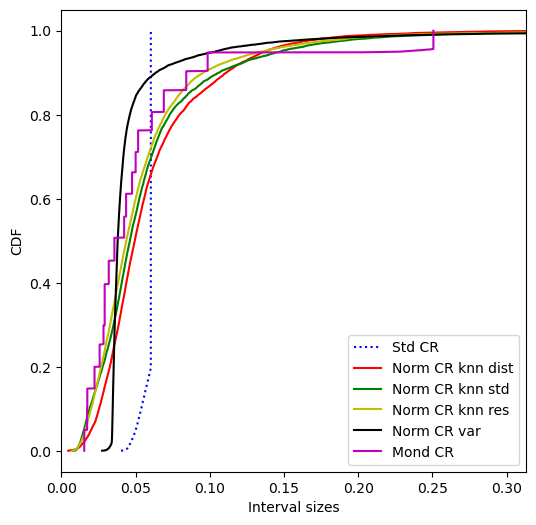

In [53]:
interval_sizes = {}
for name in prediction_intervals.keys():
    interval_sizes[name] = prediction_intervals[name][:,1] \
    - prediction_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("CDF")
plt.xlabel("Interval sizes")
plt.xlim(0,interval_sizes["Mond CR"].max()*1.25)

colors = ["b","r","g","y","k","m","c","orange"]

for i, name in enumerate(interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(interval_sizes[name]),
             [i/len(interval_sizes[name])
              for i in range(1,len(interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

### Evaluating the conformal regressors

Let us put the six above conformal regressors in a dictionary, together with the corresponding difficulty estimates for the test instances (if any).

In [54]:
all_methods = {
    "Std CR": (rf, None),
    "Norm CR knn dist": (rf_norm_knn_dist, sigmas_test_knn_dist),
    "Norm CR knn std": (rf_norm_knn_std, sigmas_test_knn_std),
    "Norm CR knn res": (rf_norm_knn_res, sigmas_test_knn_res),
    "Norm CR var" : (rf_norm_var, sigmas_test_var),
    "Mond CR": (rf_mond, sigmas_test_var)
}

Let us evaluate them using three confidence levels on the test set.
We could specify a subset of the metrics to use by the named
`metrics` argument of the `evaluate` method; here we use all, 
which is the default.

Note that the arguments `sigmas` and `bins` can always be provided,
but they will be ignored by conformal regressors not using them,
e.g., both arguments will be ignored by the standard conformal regressors.

In [55]:
confidence_levels = [0.9,0.95,0.99]

names = list(all_methods.keys())

all_results = {}

for confidence in confidence_levels:
    for name in names:
        all_results[(name,confidence)] = all_methods[name][0].evaluate(
            X_test, y=y_test, sigmas=all_methods[name][1],
            bins=bins_test, confidence=confidence, y_min=0, y_max=1)

results_df = pd.DataFrame(columns=pd.MultiIndex.from_product(
    [names,confidence_levels]), index=list(list(
    all_results.values())[0].keys()))

for key in all_results.keys():
    results_df[key] = all_results[key].values()

display(results_df.round(4))

Std CR                 Norm CR knn dist                  \
                 0.90    0.95    0.99             0.90    0.95    0.99   
error          0.0908  0.0483  0.0086           0.0929  0.0448  0.0100   
eff_mean       0.0421  0.0589  0.1190           0.0453  0.0600  0.0953   
eff_med        0.0423  0.0603  0.1205           0.0371  0.0495  0.0785   
time_fit       0.0001  0.0001  0.0001           0.0002  0.0002  0.0002   
time_evaluate  0.0006  0.0005  0.0007           0.0007  0.0007  0.0007   

              Norm CR knn std                 Norm CR knn res                  \
                         0.90    0.95    0.99            0.90    0.95    0.99   
error                  0.1050  0.0472  0.0139          0.1072  0.0497  0.0081   
eff_mean               0.0422  0.0577  0.0840          0.0409  0.0547  0.0896   
eff_med                0.0337  0.0462  0.0681          0.0326  0.0437  0.0727   
time_fit               0.0002  0.0002  0.0002          0.0002  0.0002  0.0002   
time_evaluate          0.0008  0.0008  0.0007          0.0006  0.0006  0.0011   

              Norm CR var                 Mond CR                  
                     0.90    0.95    0.99    0.90    0.95    0.99  
error              0.0999  0.0489  0.0125  0.1059  0.0475  0.0088  
eff_mean           0.0385  0.0498  0.0742  0.0409  0.0522  0.0890  
eff_med            0.0290  0.0379  0.0579  0.0269  0.0357  0.0607  
time_fit           0.0002  0.0002  0.0002  0.0005  0.0005  0.0005  
time_evaluate      0.0006  0.0005  0.0007  0.0012  0.0013  0.0011

### Conformal regressors without a separate calibration set

For conformal regressors that employ learners that use bagging, like random forests, we may consider an alternative strategy to dividing the original training set into a proper training and calibration set; we may use the out-of-bag (OOB) predictions, which allow us to use the full training set for both model building and calibration. It should be noted that this strategy does not come with the theoretical validity guarantee of the above (inductive) conformal regressors, due to that calibration and test instances are not handled in exactly the same way. In practice, however, conformal regressors based on out-of-bag predictions rarely fail to meet the coverage requirements.

#### Standard conformal regressors with out-of-bag calibration

Let us first generate a model from the full training set, making sure the learner has an attribute `oob_prediction_`, which e.g. is the case for a `RandomForestRegressor` if `oob_score` is set to `True` when created.

In [56]:
learner_full = RandomForestRegressor(n_jobs=-1, n_estimators=500, oob_score=True)

rf = WrapRegressor(learner_full)

rf.fit(X_train, y_train)

We may now obtain a standard conformal regressor using OOB predictions:

In [57]:
rf.calibrate(X_train, y_train, oob=True)

display(rf)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=False))

... and apply it using the point predictions of the full model.

In [58]:
intervals_std_oob = rf.predict_int(X_test, y_min=0, y_max=1)

display(intervals_std_oob)

array([[0.02590893, 0.08742725],
       [0.02572059, 0.08723891],
       [0.01924331, 0.08076163],
       ...,
       [0.01538734, 0.07690566],
       [0.01322211, 0.07474043],
       [0.10221904, 0.16373736]])

#### Normalized conformal regressors with out-of-bag calibration

We may also generate normalized conformal regressors from the OOB predictions. The `DifficultyEstimator` can be used also for this purpose; for the k-nearest neighbor approaches, the difficulty of each object in the training set will be computed using a leave-one-out procedure, while for the variance-based approach the out-of-bag predictions will be employed. 

By setting `oob=True`, we inform the `fit` method that we may request difficulty estimates for the provided set of objects; these will be retrieved by not providing any objects when calling the `apply` method.

Let us start with the k-nearest neighbor approach using distances only.

In [59]:
de_knn_dist_oob = DifficultyEstimator()

de_knn_dist_oob.fit(X=X_train, scaler=True, oob=True)

display(de_knn_dist_oob)

sigmas_knn_dist_oob = de_knn_dist_oob.apply()

rf.calibrate(X_train, y_train, sigmas=sigmas_knn_dist_oob, oob=True)

display(rf)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

In order to apply the normalized OOB regressors to the test set, we
need to generate difficulty estimates for the latter too.

In [60]:
sigmas_test_knn_dist_oob = de_knn_dist_oob.apply(X_test)

intervals_norm_knn_dist_oob = rf.predict_int(X_test, 
                                             sigmas=sigmas_test_knn_dist_oob, 
                                             y_min=0, y_max=1)

display(intervals_norm_knn_dist_oob)

array([[0.03946463, 0.07387155],
       [0.03968166, 0.07327784],
       [0.02624482, 0.07376013],
       ...,
       [0.        , 0.10781953],
       [0.01532777, 0.07263477],
       [0.10342399, 0.16253242]])

For completeness, we will illustrate the use of out-of-bag calibration for the remaining approaches too. For k-nearest neighbors with labels, we do the following:

In [61]:
de_knn_std_oob = DifficultyEstimator()

de_knn_std_oob.fit(X=X_train, y=y_train, scaler=True, oob=True)

display(de_knn_std_oob)

sigmas_knn_std_oob = de_knn_std_oob.apply()

rf.calibrate(X_train, y_train, sigmas=sigmas_knn_std_oob, oob=True)

display(rf)

sigmas_test_knn_std_oob = de_knn_std_oob.apply(X_test)

intervals_norm_knn_std_oob = rf.predict_int(X_test, 
                                            sigmas=sigmas_test_knn_std_oob, 
                                            y_min=0, y_max=1)

display(intervals_norm_knn_std_oob)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

array([[0.04328309, 0.07005308],
       [0.03609502, 0.07686448],
       [0.02235658, 0.07764836],
       ...,
       [0.        , 0.1122286 ],
       [0.01661292, 0.07134963],
       [0.08137641, 0.18458   ]])

A third option is to use k-nearest neighbors with (OOB) residuals:

In [62]:
residuals_oob = y_train - learner_full.oob_prediction_

de_knn_res_oob = DifficultyEstimator()

de_knn_res_oob.fit(X=X_train, residuals=residuals_oob, scaler=True, oob=True)

display(de_knn_res_oob)

sigmas_knn_res_oob = de_knn_res_oob.apply()

rf.calibrate(X_train, y_train, sigmas=sigmas_knn_res_oob, oob=True)

display(rf)

sigmas_test_knn_res_oob = de_knn_res_oob.apply(X_test)

intervals_norm_knn_res_oob = rf.predict_int(X_test, 
                                            sigmas=sigmas_test_knn_res_oob, 
                                            y_min=0, y_max=1)

display(intervals_norm_knn_res_oob)

DifficultyEstimator(fitted=True, type=knn, k=25, target=residuals, scaler=True, beta=0.01, oob=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

array([[0.03614314, 0.07719303],
       [0.03749063, 0.07546887],
       [0.02568307, 0.07432187],
       ...,
       [0.        , 0.09434338],
       [0.01525519, 0.07270736],
       [0.10487786, 0.16107854]])

A fourth and final option for the normalized conformal regressors is to use variance as a difficulty estimate. We then leave labels and residuals out, but provide an (ensemble) learner. In contrast to when `oob=False`, we are here required to provide the (full) training set, from which the variance of the out-of-bag predictions will be computed. When applied to the test set, the full ensemble model will not be used to obtain the difficulty estimates, but instead a subset of the constituent models is used, following what could be seen as post hoc assignment of each test instance to a bag.      

In [63]:
de_var_oob = DifficultyEstimator()

de_var_oob.fit(X=X_train, learner=learner_full, scaler=True, oob=True)

display(de_var_oob)

sigmas_var_oob = de_var_oob.apply()

rf.calibrate(X_train, y_train, sigmas=sigmas_var_oob, oob=True)

display(rf)

sigmas_test_var_oob = de_var_oob.apply(X_test)

intervals_norm_var_oob = rf.predict_int(X_test, sigmas=sigmas_test_var_oob,
                                        y_min=0, y_max=1)

display(intervals_norm_var_oob)

DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=True)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=True, mondrian=False))

array([[0.03807088, 0.07526529],
       [0.03662524, 0.07633426],
       [0.03028454, 0.0697204 ],
       ...,
       [0.02440044, 0.06789256],
       [0.02293055, 0.065032  ],
       [0.08729911, 0.1786573 ]])

#### Mondrian conformal regressors with out-of-bag calibration

We may form the categories using the difficulty estimates obtained from the OOB predictions. We here consider the difficulty estimates produced by the fourth above option (using variance) only. 

In [64]:
bins_oob, bin_thresholds_oob = binning(sigmas_var_oob, bins=20)

rf.calibrate(X_train, y_train, bins=bins_oob, oob=True)

display(rf)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalRegressor(fitted=True, normalized=False, mondrian=True))

... and assign the categories for the test instances, ...

In [65]:
bins_test_oob = binning(sigmas_test_var_oob, bins=bin_thresholds_oob)

... and finally generate the prediction intervals.

In [66]:
intervals_mond_oob = rf.predict_int(X_test,
                                    bins=bins_test_oob,
                                    y_min=0, y_max=1)

display(intervals_mond_oob)

array([[0.04631242, 0.06702375],
       [0.03769907, 0.07526043],
       [0.0338074 , 0.06619754],
       ...,
       [0.02007812, 0.07221488],
       [0.02066363, 0.06729892],
       [0.00935957, 0.25659683]])

### Investigating the OOB prediction intervals

In [67]:
prediction_intervals = {
    "Std CR OOB":intervals_std_oob,
    "Norm CR knn dist OOB":intervals_norm_knn_dist_oob,
    "Norm CR knn std OOB":intervals_norm_knn_std_oob,
    "Norm CR knn res OOB":intervals_norm_knn_res_oob,
    "Norm CR var OOB":intervals_norm_var_oob,
    "Mond CR OOB":intervals_mond_oob,
}

Let us see what fraction of the intervals that contain the true targets and how large the intervals are.

In [68]:
coverages = []
mean_sizes = []
median_sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(prediction_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CR OOB,0.9545,0.0600,0.0615
Norm CR knn dist OOB,0.9525,0.0582,0.0482
Norm CR knn std OOB,0.9553,0.0586,0.0462
Norm CR knn res OOB,0.9546,0.0537,0.0427
Norm CR var OOB,0.9534,0.0497,0.0396
Mond CR OOB,0.9535,0.0510,0.0376
Mean,0.9540,0.0552,0.0460


Let us look at the distribution of the interval sizes.

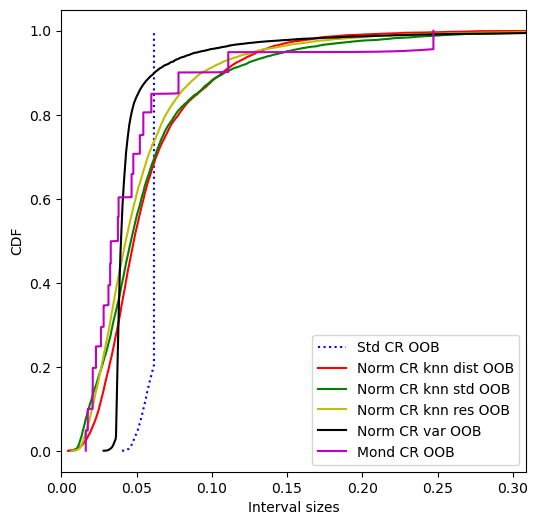

In [69]:
interval_sizes = {}
for name in prediction_intervals.keys():
    interval_sizes[name] = prediction_intervals[name][:,1] \
    - prediction_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("CDF")
plt.xlabel("Interval sizes")
plt.xlim(0,interval_sizes["Mond CR OOB"].max()*1.25)

colors = ["b","r","g","y","k","m","c","orange"]

for i, name in enumerate(interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(interval_sizes[name]),
             [i/len(interval_sizes[name])
              for i in range(1,len(interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

## Conformal Predictive Systems (CPS)

### Creating and fitting CPS

Conformal predictive systems are created through the `WrapRegressor` class in the same way as conformal regressors. We specify that a conformal predictive system, rather than a conformal regressor, should be formed by providing `cps=True` when calling the `calibrate` method (default is `cps=False`).

Let us start by generating standard and normalized conformal predictive systems (CPS), using the previously fitted `learner_prop`, as well two conformal predictive systems relying on out-of-bag predictions, using the previously fitted `learner_full` with and without normalization.

In [70]:
cps_std = WrapRegressor(learner_prop)

cps_std.calibrate(X_cal, y_cal, cps=True)

display(cps_std)

cps_norm = WrapRegressor(learner_prop).calibrate(X_cal, y_cal,
                                        sigmas=sigmas_cal_var,
                                        cps=True)
display(cps_norm)

cps_std_oob = WrapRegressor(learner_full).calibrate(X_train, y_train,
                                                    oob=True, cps=True)
display(cps_std_oob)

cps_norm_oob = WrapRegressor(learner_full).calibrate(X_train, y_train,
                                                     sigmas=sigmas_var_oob,
                                                     oob=True, cps=True)
display(cps_norm_oob)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=False))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=False))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=False))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=False))

Let us also create some Mondrian CPS, but in contrast to the Mondrian conformal regressors above, we here form the categories through binning of the predictions rather than binning of the difficulty estimates. We may use the latter, i.e., the sigmas, to obtain a normalized CPS for each category (bin).

In [71]:
bins_cal, bin_thresholds = binning(learner_prop.predict(X_cal), bins=5)

cps_mond_std = WrapRegressor(learner_prop)
cps_mond_std.calibrate(X_cal, y_cal, bins=bins_cal, cps=True)

display(cps_mond_std)

cps_mond_norm = WrapRegressor(learner_prop)
cps_mond_norm.calibrate(X_cal, y_cal, sigmas=sigmas_cal_var, 
                        bins=bins_cal, cps=True)

display(cps_mond_norm)

bins_oob, bin_thresholds_oob = binning(learner_full.oob_prediction_, bins=5)

cps_mond_std_oob = WrapRegressor(learner_full)
cps_mond_std_oob.calibrate(X_train, y_train, bins=bins_oob, 
                           oob=True, cps=True)

display(cps_mond_std_oob)

cps_mond_norm_oob = WrapRegressor(learner_full)
cps_mond_norm_oob.calibrate(X_train, y_train,
                            sigmas=sigmas_var_oob,
                            bins=bins_oob,
                            oob=True, cps=True)

display(cps_mond_norm_oob)

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=True))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=True))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=False, mondrian=True))

WrapRegressor(learner=RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True), calibrated=True, predictor=ConformalPredictiveSystem(fitted=True, normalized=True, mondrian=True))

### Making predictions

For the normalized approaches, we already have the difficulty estimates which are needed for the test instances. 
For the Mondrian approaches, we also need to assign the new categories to the test instances.

In [72]:
y_hat_test = learner_prop.predict(X_test)

bins_test = binning(y_hat_test, bins=bin_thresholds)

bins_test_oob = binning(y_hat_test, bins=bin_thresholds_oob)

We still have access to the usual `predict` method, to obtain point predictions of the wrapped learner, as well as the `predict_int` method, which works as for conformal regressors. In addition, there is now a method called `predict_cps`, for which the output will depend on how we specify the input. If we provide specific target values (using the parameter `y`), the method will output a p-value for each test instance, i.e., the probability that the true target is less than or equal to the provided values. The method assumes that either one value is provided for each test instance or that the same (single) value is provided for all test instances.

Here we will obtain the p-values from `cps_mond_norm` for the true targets of the test set:

In [73]:
p_values = cps_mond_norm.predict_cps(X_test,
                                     sigmas=sigmas_test_knn_res,
                                     bins=bins_test,
                                     y=y_test)

display(p_values)

array([0.3151262 , 0.48478441, 0.4968724 , ..., 0.54357433, 0.54652833,
       0.57443122])

If we instead would like to get threshold values, with a specified probability that the true target is less than the threshold for each test instance, we may instead provide percentiles as input to the `predict` method. This is done through the parameter
`lower_percentiles`, which denotes (one or more) percentiles for which a lower value
will be selected in case a percentile lies between two values
(similar to `interpolation="lower"` in `numpy.percentile`), or using
`higher_percentiles`, which denotes (one or more) percentiles for which a higher value
will be selected in such cases (similar to `interpolation="higher"` in `numpy.percentile`).

Here we will obtain the lowest values from `cps_mond_norm`, such that the probability for the target values being less than these is at least 50%:

In [74]:
thresholds = cps_mond_norm.predict_cps(X_test,
                                       sigmas=sigmas_test_knn_res,
                                       bins=bins_test,
                                       higher_percentiles=50)

display(thresholds)

array([0.0570735 , 0.05206341, 0.04397814, ..., 0.04417872, 0.03882627,
       0.11961791])

We can also specify both target values and percentiles; the resulting p-values will be returned in the first column, while any values corresponding to the lower percentiles will be included in the subsequent columns, followed by columns containing the values corresponding to the higher percentiles. The following call hence results in an array with five columns:

In [75]:
results = cps_mond_norm.predict_cps(X_test,
                                    sigmas=sigmas_test_knn_res,
                                    bins=bins_test,
                                    y=y_test,
                                    lower_percentiles=[2.5, 5],
                                    higher_percentiles=[95, 97.5])

display(results)

array([[ 0.31435586, -0.06619505, -0.0386976 ,  0.1560177 ,  0.19735863],
       [ 0.48613455, -0.05238774, -0.03454503,  0.14860673,  0.17581211],
       [ 0.49610169, -0.07765735, -0.05687914,  0.15640479,  0.18808601],
       ...,
       [ 0.54484538, -0.15524008, -0.12117465,  0.22849982,  0.2804405 ],
       [ 0.54701261, -0.10075311, -0.06139008,  0.13901646,  0.20103844],
       [ 0.5752651 , -0.02287191, -0.0029496 ,  0.2931676 ,  0.34550542]])

In addition to p-values and threshold values, we can request that the `predict_cps` method returns the full conformal predictive distribution (CPD) for each test instance, as defined by the threshold values, by setting `return_cpds=True`. The format of the distributions vary with the type of conformal predictive system; for a standard and normalized CPS, the output is an array with a row for each test instance and a column for each calibration instance (residual), while for a Mondrian CPS, the default output is a vector containing one CPD per test instance (since the number of values may vary between categories). If the desired output instead is an array of distributions per category, where all distributions in a category have the same number of columns, which in turn depends on the number of calibration instances in the corresponding category, then `cpds_by_bins=True` may be specified. In case `return_cpds=True` is specified together with `y`, `lower_percentiles` or `higher_percentiles`, the output of `predict` will be a pair, with the first element holding the results of the above type and the second element will contain the CPDs. 

For the above Mondrian CPS, the following call to `predict_cps` will result in a vector of distributions, with one element for each test instance.

In [76]:
cpds = cps_mond_norm.predict_cps(X_test,
                                 sigmas=sigmas_test_knn_res,
                                 bins=bins_test,
                                 return_cpds=True)

print(f"No. of test instances: {len(y_hat_test)}")
print(f"Shape of cpds: {cpds.shape}")

No. of test instances: 10807
Shape of cpds: (10807,)


If we instead would prefer to represent these distributions by one array per category, we set `cpds_by_bins=True`, noting that it will be a bit trickier to associate a test instance to a specific distribution.  

In [77]:
cpds = cps_mond_norm.predict_cps(X_test,
                                 sigmas=sigmas_test_knn_res,
                                 bins=bins_test,
                                 return_cpds=True, 
                                 cpds_by_bins=True)

for i, cpd in enumerate(cpds):
    print(f"bin {i}: {cpd.shape[0]} test instances, {cpd.shape[1]} threshold values")

print(f"No. of test instances: {sum([c.shape[0] for c in cpds])}")

bin 0: 2274 test instances, 541 threshold values
bin 1: 2227 test instances, 540 threshold values
bin 2: 2056 test instances, 540 threshold values
bin 3: 2183 test instances, 540 threshold values
bin 4: 2067 test instances, 541 threshold values
No. of test instances: 10807


We may also plot the conformal predictive distribution for some test object. In case the calibration set is very large, you may consider plotting an approximation of the full distribution by using a grid of values for `lower_percentiles` or `higher_percentiles`, instead of setting `return_cpds=True`. For the Mondrian CPS, the size of the calibration set for each bin is reasonable in this case, so we may just use the distributions directly.

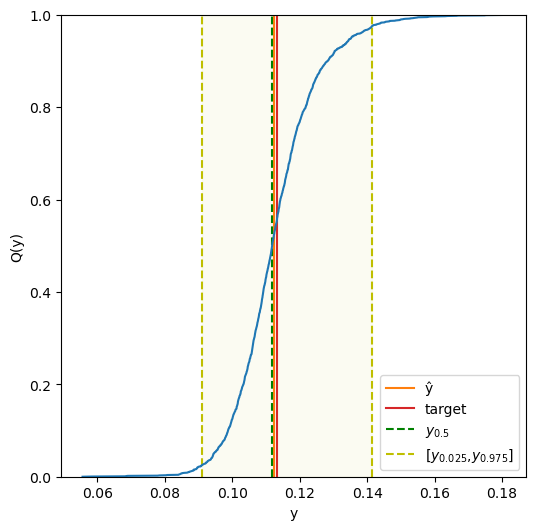

In [78]:
cpds = cps_mond_norm_oob.predict_cps(X_test,
                                     bins=bins_test_oob,
                                     sigmas=sigmas_test_var_oob,
                                     return_cpds=True)

test_index = np.random.randint(len(X_test)) # A test object is randomly selected
cpd = cpds[test_index]

p = np.array([i/len(cpd) for i in range(len(cpd))])

lower_index = np.where(p<=0.025)[0][-1]
mid_index = np.where(p>=0.50)[0][0]
upper_index = np.where(p>=0.975)[0][0]

low_percentile = cpd[lower_index]
median = cpd[mid_index]
high_percentile = cpd[upper_index]

plt.figure(figsize=(6,6))

y_hat = cps_mond_norm_oob.predict(X_test[test_index][None,:])

plt.plot([y_hat,y_hat],[0,1], color="tab:orange")
plt.plot([y_test[test_index],y_test[test_index]],[0,1], color="tab:red")
plt.xlabel("y")
plt.ylabel("Q(y)")
plt.ylim(0,1)

plt.plot([median,median],[0,1],"g--")
plt.plot([low_percentile,low_percentile],[0,1],"y--")
plt.legend(["ŷ","target","$y_{0.5}$","[$y_{0.025}$,$y_{0.975}$]"])
plt.plot([high_percentile,high_percentile],[0,1],"y--")
plt.plot(cpd,p, color="tab:blue")
rectangle = plt.Rectangle((low_percentile,0),
                          abs(high_percentile-low_percentile),1, color="y", 
                          alpha=0.05)
plt.gca().add_patch(rectangle)
plt.show()

### Analyzing the p-values

Let us put all the generated CPS in a dictionary.

In [79]:
all_cps = {"Std CPS":cps_std,
           "Std OOB CPS":cps_std_oob,
           "Norm CPS":cps_norm,
           "Norm OOB CPS":cps_norm_oob,
           "Mond CPS":cps_mond_std,
           "Mond OOB CPS":cps_mond_std_oob,
           "Mond norm CPS":cps_mond_norm,
           "Mond norm OOB CPS":cps_mond_norm_oob
          }

Now we will check if the p-values for the test targets seem to be uniformly distributed.

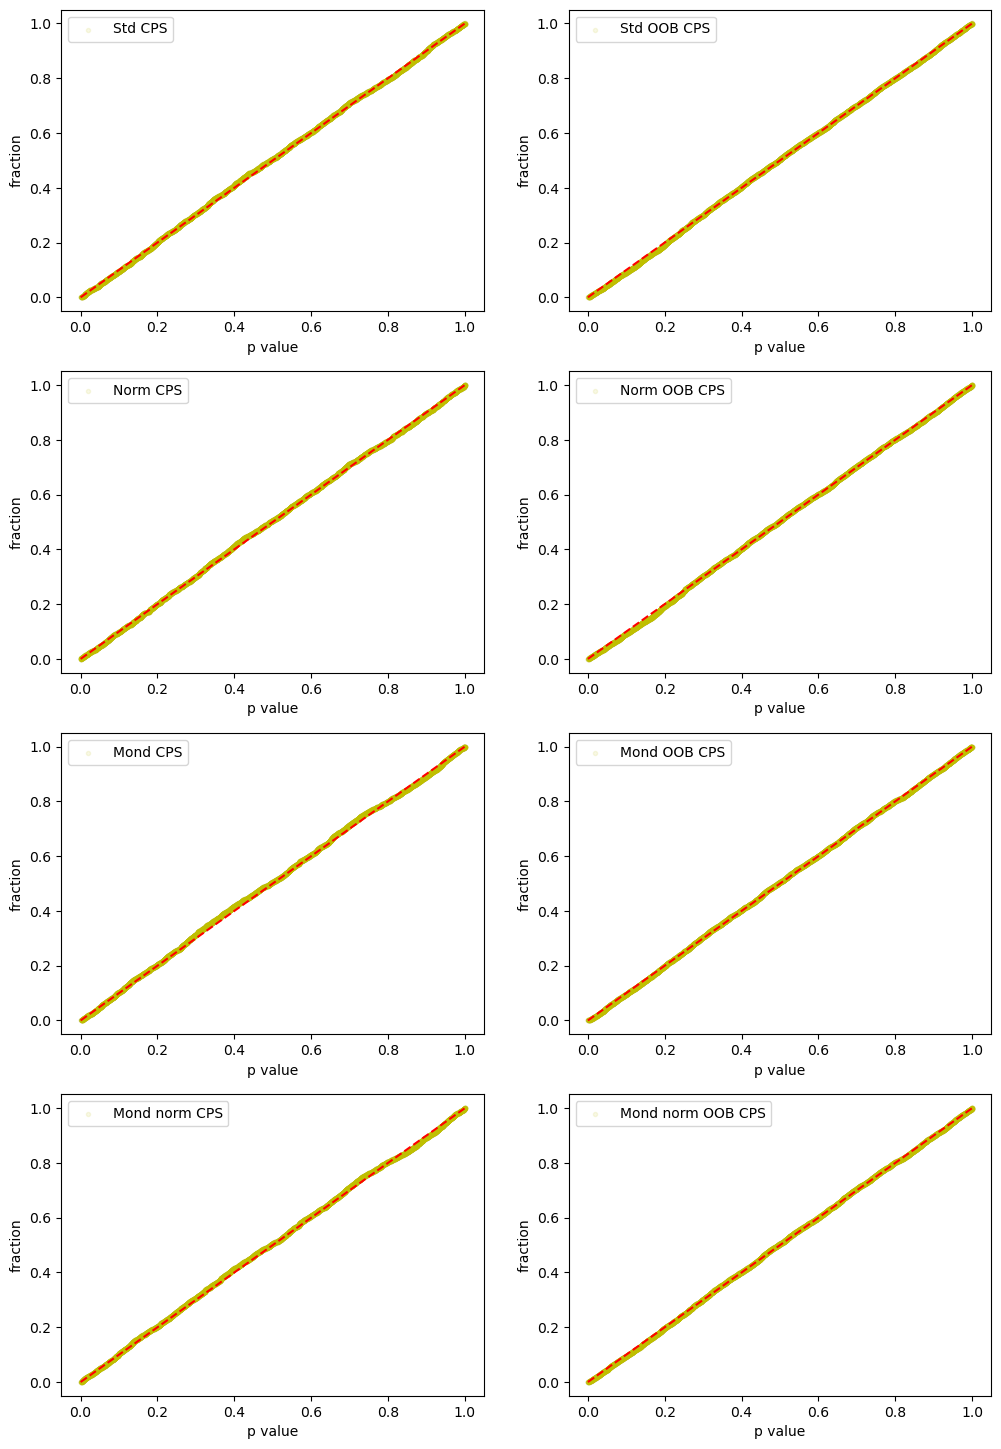

In [80]:
plt.subplots(len(all_cps.keys())//2,2,figsize=(12,18))

for i, name in enumerate(all_cps.keys()):
    if "OOB" in name:
        p_values = all_cps[name].predict_cps(X_test, 
                                             sigmas=sigmas_test_var_oob,
                                             bins=bins_test_oob, 
                                             y=y_test)
    else:
        p_values = all_cps[name].predict_cps(X_test, 
                                             sigmas=sigmas_test_var, 
                                             bins=bins_test, 
                                             y=y_test)

    plt.subplot(len(all_cps.keys())//2,2,i+1)

    plt.scatter(np.sort(p_values),
                [(i+1)/len(y_test) for i in range(len(y_test))],
                label=name, c="y", marker=".", alpha=0.1)

    plt.plot([0,1],[0,1],"r--")
    plt.legend()
    plt.ylabel("fraction")
    plt.xlabel("p value")

plt.show()

### Investigating the coverage and size of extracted prediction intervals

Let us investigate the extracted prediction intervals at the 95% confidence level. 
This is done by a specifying percentiles corresponding to the interval endpoints.

In [81]:
all_cps_intervals = {}

coverages = []
mean_sizes = []
median_sizes = []

for name in all_cps.keys():
    if "OOB" in name:
        intervals = all_cps[name].predict_int(X_test, 
                                              sigmas=sigmas_test_var_oob, 
                                              bins=bins_test_oob,
                                              y_min=0, y_max=1)
    else:
        intervals = all_cps[name].predict_int(X_test, 
                                              sigmas=sigmas_test_var, 
                                              bins=bins_test,
                                              y_min=0, y_max=1)
    all_cps_intervals[name] = intervals
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(all_cps_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CPS,0.9478,0.0591,0.0598
Std OOB CPS,0.9540,0.0609,0.0618
Norm CPS,0.9486,0.0498,0.0378
Norm OOB CPS,0.9545,0.0508,0.0404
Mond CPS,0.9546,0.0564,0.0386
Mond OOB CPS,0.9571,0.0578,0.0407
Mond norm CPS,0.9547,0.0527,0.0361
Mond norm OOB CPS,0.9551,0.0515,0.0381
Mean,0.9533,0.0549,0.0442


### Investigating the distributions of extracted prediction intervals

Let us take a look at the distribution of the interval sizes.

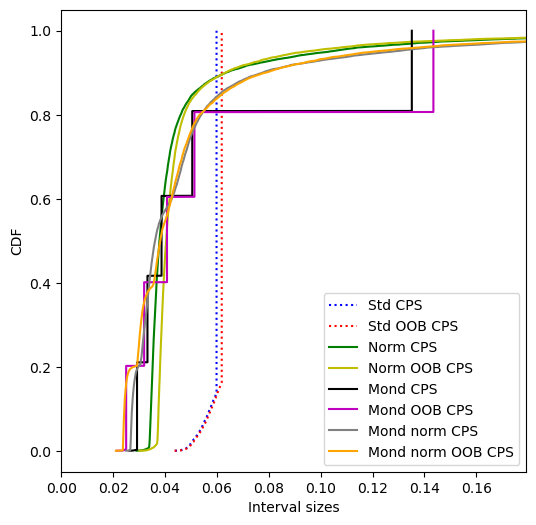

In [82]:
cps_interval_sizes = {}

for name in all_cps_intervals.keys():
    cps_interval_sizes[name] = \
    all_cps_intervals[name][:,1] - all_cps_intervals[name][:,0]

plt.figure(figsize=(6,6))
plt.ylabel("CDF")
plt.xlabel("Interval sizes")
plt.xlim(0,cps_interval_sizes["Mond OOB CPS"].max()*1.25)

colors = ["b","r","g","y","k","m", "gray", "orange"]

for i, name in enumerate(cps_interval_sizes.keys()):
    if "Std" in name:
        style = "dotted"
    else:
        style = "solid"
    plt.plot(np.sort(cps_interval_sizes[name]),
             [i/len(cps_interval_sizes[name])
              for i in range(1,len(cps_interval_sizes[name])+1)],
             linestyle=style, c=colors[i], label=name)

plt.legend()
plt.show()

### Extracting medians

Let us take a look at the medians; they can be derived using either lower or higher interpolation,
but ideally the differences should be small.

In [83]:
all_cps_medians = {}

for name in all_cps.keys():
    if "OOB" in name:
        medians = all_cps[name].predict_cps(X_test, 
                                            sigmas=sigmas_test_var_oob, 
                                            bins=bins_test_oob,
                                            lower_percentiles=50, 
                                            higher_percentiles=50)
    else:
        medians = all_cps[name].predict_cps(X_test, 
                                            sigmas=sigmas_test_var, 
                                            bins=bins_test,
                                            lower_percentiles=50, 
                                            higher_percentiles=50)
    all_cps_medians[name] = medians
    print(name)
    print("\tMean difference of the medians:    {:.6f}".format((medians[:,1]-medians[:,0]).mean()))
    print("\tLargest difference of the medians: {:.6f}".format((medians[:,1]-medians[:,0]).max()))

Std CPS
	Mean difference of the medians:    0.000008
	Largest difference of the medians: 0.000008
Std OOB CPS
	Mean difference of the medians:    0.000003
	Largest difference of the medians: 0.000003
Norm CPS
	Mean difference of the medians:    0.000002
	Largest difference of the medians: 0.000093
Norm OOB CPS
	Mean difference of the medians:    0.000001
	Largest difference of the medians: 0.000070
Mond CPS
	Mean difference of the medians:    0.000028
	Largest difference of the medians: 0.000104
Mond OOB CPS
	Mean difference of the medians:    0.000000
	Largest difference of the medians: 0.000002
Mond norm CPS
	Mean difference of the medians:    0.000027
	Largest difference of the medians: 0.000213
Mond norm OOB CPS
	Mean difference of the medians:    0.000000
	Largest difference of the medians: 0.000003


### Another view of the medians and prediction intervals

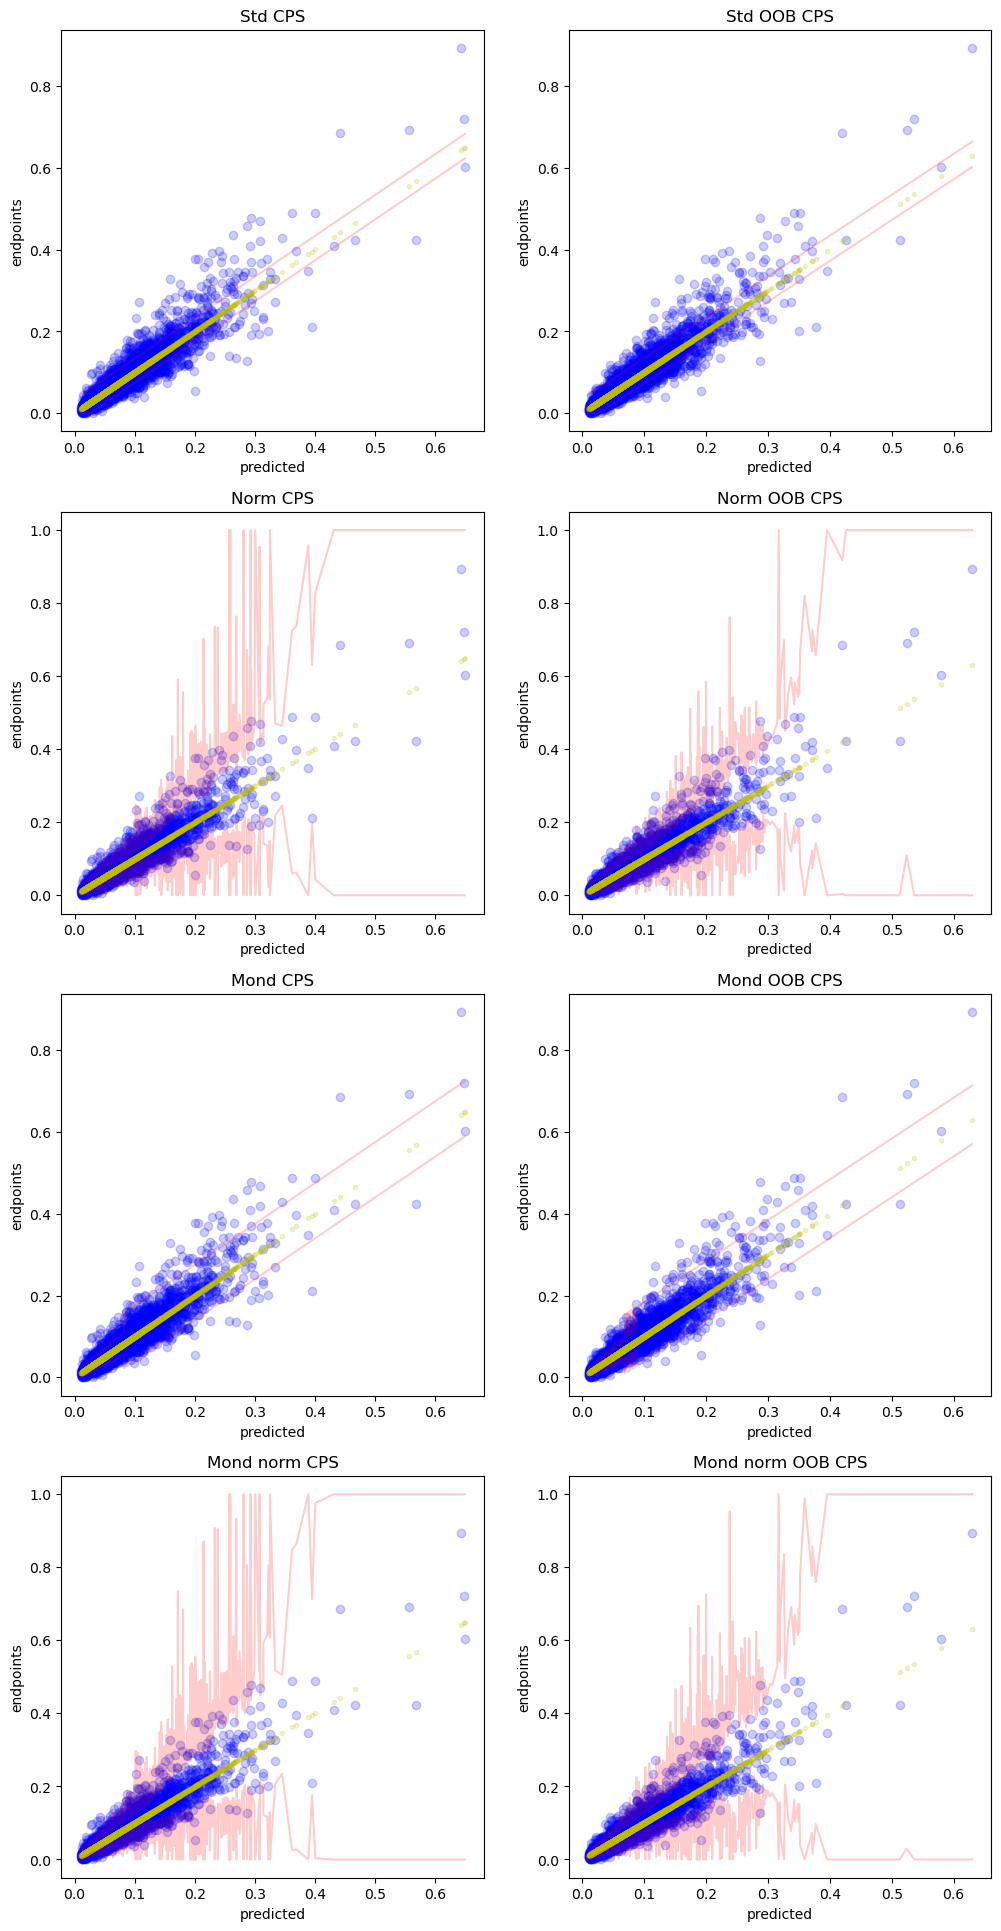

In [84]:
y_hat_full = learner_full.predict(X_test)

plt.subplots(len(all_cps_intervals.keys())//2,2,figsize=(12,24))

sorted_prop_indexes = np.argsort(y_hat_test) 

sorted_full_indexes = np.argsort(y_hat_full) 

alpha=0.2

for i, name in enumerate(all_cps_intervals.keys()):

    plt.subplot(len(all_cps_intervals.keys())//2,2,i+1)
    if "OOB" in name:
        indexes = sorted_full_indexes
        y_hat_ = y_hat_full
    else:
        indexes = sorted_prop_indexes
        y_hat_ = y_hat_test

    plt.title(name)
    plt.plot(y_hat_[indexes], all_cps_intervals[name][indexes,0], 
             color="r", alpha=alpha)
    plt.plot(y_hat_[indexes], all_cps_intervals[name][indexes,1], 
             color="r", alpha=alpha)
    plt.scatter(y_hat_[indexes],y_test[indexes],
                color="b", marker="o", alpha=alpha)
    plt.scatter(y_hat_[indexes],y_hat_[indexes],
                color="y", marker=".", alpha=alpha)
    plt.xlabel("predicted")
    plt.ylabel("endpoints")

plt.show()

### Evaluating the CPS using a test set

Let us evaluate the generated CPS using three confidence levels on the test set.
We could specify a subset of the metrics to use by the
`metrics` parameter of the `evaluate` method; here we use all metrics, 
which is the default

Note that values for the parameters `sigmas` and `bins` can always be provided,
but they will be ignored by CPS that have not been fitted with such values,
e.g., both arguments will be ignored by the standard CPS.

Note that CRPS takes some time to compute, in particular when the CPS have been fitted with 
larger calibration sets.

In [85]:
confidence_levels = [0.9,0.95,0.99]

names = np.array(list(all_cps.keys()))

first_set = names[["OOB" not in name for name in names]]
second_set = names[["OOB" in name for name in names]]

for methods in [first_set, second_set]:
    all_cps_results = {}
    for confidence in confidence_levels:
        for name in methods:
            if "OOB" in name:
                all_cps_results[(name,confidence)] = all_cps[name].evaluate(
                    X_test, y=y_test, sigmas=sigmas_test_var_oob, 
                    bins=bins_test_oob, confidence=confidence, 
                    y_min=0, y_max=1)
            else:
                all_cps_results[(name,confidence)] =  all_cps[name].evaluate(
                    X_test, y=y_test, sigmas=sigmas_test_var, 
                    bins=bins_test, confidence=confidence, y_min=0, y_max=1)

    cps_results_df = pd.DataFrame(columns=pd.MultiIndex.from_product(
        [methods,confidence_levels]), index=list(list(
        all_cps_results.values())[0].keys()))

    for key in all_cps_results.keys():
        cps_results_df[key] = all_cps_results[key].values()

    display(cps_results_df.round(4))

Std CPS                 Norm CPS                 Mond CPS  \
                 0.90    0.95    0.99     0.90    0.95    0.99     0.90   
error          0.0923  0.0522  0.0084   0.0980  0.0514  0.0131   0.0988   
eff_mean       0.0423  0.0591  0.1213   0.0390  0.0498  0.0725   0.0422   
eff_med        0.0424  0.0598  0.1261   0.0294  0.0378  0.0560   0.0303   
CRPS           0.0072  0.0072  0.0072   0.0068  0.0068  0.0068   0.0069   
time_fit       0.0001  0.0001  0.0001   0.0001  0.0001  0.0001   0.0003   
time_evaluate  0.4149  0.3805  0.3796   0.4150  0.4306  0.4251   0.2487   

                              Mond norm CPS                  
                 0.95    0.99          0.90    0.95    0.99  
error          0.0454  0.0068        0.1044  0.0453  0.0075  
eff_mean       0.0564  0.0996        0.0407  0.0527  0.0798  
eff_med        0.0386  0.0672        0.0285  0.0361  0.0585  
CRPS           0.0069  0.0069        0.0067  0.0067  0.0067  
time_fit       0.0003  0.0003        0.0004  0.0004  0.0004  
time_evaluate  0.2559  0.2468        0.2799  0.2771  0.2812

Std OOB CPS                 Norm OOB CPS                  \
                     0.90    0.95    0.99         0.90    0.95    0.99   
error              0.0925  0.0460  0.0073       0.0945  0.0455  0.0106   
eff_mean           0.0414  0.0609  0.1310       0.0386  0.0508  0.0758   
eff_med            0.0416  0.0618  0.1358       0.0306  0.0404  0.0611   
CRPS               0.0070  0.0070  0.0070       0.0067  0.0067  0.0067   
time_fit           0.0005  0.0005  0.0005       0.0005  0.0005  0.0005   
time_evaluate      0.9034  0.7962  0.7779       0.8537  0.8730  0.8520   

              Mond OOB CPS                 Mond norm OOB CPS                  
                      0.90    0.95    0.99              0.90    0.95    0.99  
error               0.0977  0.0429  0.0068            0.0958  0.0449  0.0087  
eff_mean            0.0417  0.0578  0.1002            0.0407  0.0515  0.0783  
eff_med             0.0308  0.0407  0.0632            0.0299  0.0381  0.0582  
CRPS                0.0068  0.0068  0.0068            0.0066  0.0066  0.0066  
time_fit            0.0007  0.0007  0.0007            0.0009  0.0009  0.0009  
time_evaluate       0.3322  0.3209  0.3184            0.3610  0.3592  0.3633